In [1]:
import numpy as np
import pandas as pd
import re
from os.path import join

from tools import *

from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial import distance

import matplotlib.pyplot as plt
import numpy as np

## rename EXTRACT_FEATURES to DIMENSION_REDUCTION
read_prefix = "/data/MIMIC3/"
write_prefix = "/data/liu/LDA"
res_prefix = "/data/liu/LDA/lda_result"
res_r_prefix = "/data/liu/LDA/lda_R_result/"

In [2]:
diag_matrix = read_data(join(write_prefix, "diag_matrix_filtered"))
pres_matrix = read_data(join(write_prefix, "pres_matrix_filtered"))

In [3]:
## Get top NDC, top columns should include these NDCs regardless of their frequency
top10_NDC_ade = read_data(join(write_prefix,'top10_NDC_ade'),dtype={'NDC':str})
top10_NDCs = top10_NDC_ade['NDC']

## General comparison for patients taking or non-taking each drug

In [4]:
def mean_validation(pres_matrix, diag_matrix, top10_NDCs,ade_df, ndc_indexes,union=False,topNs=[30,100,1000],n_digits=2):
    res = []
    
    ndc_list = [top10_NDCs[i] for i in ndc_indexes]
    pres_NDC_df = pres_matrix[ndc_list]
    if(union==True):
        pres_NDC_df['prod'] = pres_NDC_df.max(axis=1)
    else:
        pres_NDC_df['prod'] = pres_NDC_df.prod(axis=1)
    
    all_index = pres_NDC_df.index
    treat_index = pres_NDC_df[pres_NDC_df['prod']==1].index
    control_index = list(set(all_index)-set(treat_index))
    
    treat_diag=diag_matrix.loc[treat_index].agg('mean').fillna(0)
    control_diag=diag_matrix.loc[control_index].agg('mean').fillna(0)
    compare_diag = treat_diag-control_diag
    predict_ade = compare_diag[compare_diag>0].sort_values(ascending=False).index
    selected_ades = ade_df[ade_df['NDC'].isin(ndc_list)]
    
    ## Union of diseases for a drug set
    if(union==True):
        true_ade = set.union(*[set(df['ICD9_CODE']) for _,df in selected_ades.groupby('NDC')])
    else:
    #intersection of disease of each drug in a drug set
        true_ade = set.intersection(*[set(df['ICD9_CODE']) for _,df in selected_ades.groupby('NDC')])
    true_ade_len = len(true_ade)
    
    res=res+[(',').join(['drug_%d'%i for i in ndc_indexes]), len(treat_index), true_ade_len]
    for topn in topNs:
        predict_ade_top = predict_ade[:topn]
        true_positive = set(predict_ade_top).intersection(true_ade)
        if(len(true_positive)==0):
            res=res+[0,0]
        else:
            precision = round(len(true_positive)/topn*100,n_digits)
            recall = round(len(true_positive)/true_ade_len*100,n_digits)
            res=res+[precision, recall]
    return res, len(res)

In [5]:
def base_pred_each_ndcset(ade_df,top10_NDCs, ndc_set_list,pres_matrix, diag_matrix, union=False,topNs=[30,100,1000]):
    ##ndc_set_list: [[2,3],[1],[2,3,9]]
    l=[]
    
    for NDC_index in ndc_set_list:
        ## NDC_index: [0],[1,2,4]
        res, res_len = mean_validation(pres_matrix, diag_matrix, top10_NDCs, ade_df,NDC_index,union,topNs)
        l = l + res
#         pres_NDC_df = pres_matrix[[NDC]]
#         all_index = pres_NDC_df.index
#         treat_index = pres_NDC_df[pres_NDC_df[NDC]==1].index
#         control_index = list(set(all_index)-set(treat_index))


#         treat_diag=diag_matrix.loc[treat_index].agg('mean')
#         control_diag=diag_matrix.loc[control_index].agg('mean')
#         predict_ade = (treat_diag-control_diag).sort_values(ascending=False)
#         true_ade = set(ade_df[ade_df['NDC']==NDC]['ICD_CODE'].unique())
#         true_ade_len = len(true_ade)
#         l=l+['drug_%d'%i, len(treat_index), true_ade_len]
#         i=i+1
#         for topn in topNs:
#             predict_ade_top = predict_ade[:topn]
#             true_positive = set(predict_ade_top).intersection(true_ade)
#             precision = len(true_positive)/topn*100
#             recall = len(true_positive)/true_ade_len*100
#             l=l+[precision, recall]
    l_df = pd.DataFrame(np.reshape(l,[-1,res_len]),\
                        columns=['drug_set','num(treated_patient)','len(true_ade)']+['precision%','recall%']*len(topNs))
    return l_df

In [14]:
c = []
c=c+[[0,7,9]]
c=c+[[1,4,9]]
c=c+[[7]]
c=c+[[4]]
c=c+[[0,1]]
c=c+[[3,4,9]]
c=c+[[3,7,8]]
c=c+[[0,1,2,9]]
c=c+[[1,8]]
c=c+[[4]]

In [7]:
## RUN! Get True ADEs (ICD9)
sideffect_prefix = '/data/liu/adverse_events'
ade_df = read_data(join(sideffect_prefix, 'ndc_icd9_side_effects'), 
                   dtype={'NDC':str},usecols=['NDC','ICD9_CODE'])


/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [65]:
# selected_ades= ade_df[ade_df['NDC'].isin(top10_NDCs[drug_set])]
# ture_ade = []
# u = set.intersection(*[set(df['ICD9_CODE']) for _,df in selected_ades.groupby('NDC')])

In [67]:
# drug_set = [0,7,9]
# ade_df[ade_df['NDC'].isin(top10_NDCs[drug_set])]

In [8]:
base_pred_each_ndcset(ade_df,top10_NDCs, [[i] for i in list(range(10))],pres_matrix, diag_matrix)

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,drug_set,num(treated_patient),len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
0,drug_0,26,623,40.0,1.93,28.0,4.49,4.6,7.38
1,drug_1,58,623,43.33,2.09,36.0,5.78,7.3,11.72
2,drug_2,4,451,13.33,0.89,6.0,1.33,0.6,1.33
3,drug_3,73,513,23.33,1.36,19.0,3.7,9.2,17.93
4,drug_4,531,513,26.67,1.56,29.0,5.65,11.1,21.64
5,drug_5,5,562,23.33,1.25,31.0,5.52,3.6,6.41
6,drug_6,3,562,20.0,1.07,15.0,2.67,1.5,2.67
7,drug_7,479,512,0,0,6.0,1.17,0.6,1.17
8,drug_8,6,334,20.0,1.8,9.0,2.69,0.9,2.69
9,drug_9,132,334,36.67,3.29,22.0,6.59,5.2,15.57


In [9]:
base_pred_each_ndcset(ade_df,top10_NDCs, c,pres_matrix, diag_matrix)

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,drug_set,num(treated_patient),len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
0,"drug_0,drug_7,drug_9",0,252,0,0,0,0,0,0
1,"drug_1,drug_4,drug_9",0,253,0,0,0,0,0,0
2,drug_7,479,512,0,0,6.0,1.17,0.6,1.17
3,drug_4,531,513,26.67,1.56,29.0,5.65,11.1,21.64
4,"drug_0,drug_1",6,623,33.33,1.61,17.0,2.73,1.7,2.73
5,"drug_3,drug_4,drug_9",0,268,0,0,0,0,0,0
6,"drug_3,drug_7,drug_8",0,267,0,0,0,0,0,0
7,"drug_0,drug_1,drug_2,drug_9",0,247,0,0,0,0,0,0
8,"drug_1,drug_8",0,282,0,0,0,0,0,0
9,drug_4,531,513,26.67,1.56,29.0,5.65,11.1,21.64


In [37]:
base_pred_each_ndcset(ade_df,top10_NDCs, c,pres_matrix, diag_matrix,union=True)

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,drug_set,num(treated_patient),len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
0,"drug_0,drug_7,drug_9",637,752,0,0,14.0,1.86,4.0,5.32
1,"drug_1,drug_4,drug_9",719,752,43.33,1.73,39.0,5.19,16.8,22.34
2,drug_7,479,512,0,0,6.0,1.17,0.6,1.17
3,drug_4,531,513,26.67,1.56,29.0,5.65,11.1,21.64
4,"drug_0,drug_1",78,623,36.67,1.77,38.0,6.1,8.0,12.84
5,"drug_3,drug_4,drug_9",726,579,33.33,1.73,34.0,5.87,13.5,23.32
6,"drug_3,drug_7,drug_8",558,579,0,0,7.0,1.21,2.1,3.63
7,"drug_0,drug_1,drug_2,drug_9",214,739,43.33,1.76,42.0,5.68,13.1,17.73
8,"drug_1,drug_8",64,675,46.67,2.07,34.0,5.04,7.8,11.56
9,drug_4,531,513,26.67,1.56,29.0,5.65,11.1,21.64


In [43]:
pres_NDC_df = pres_matrix[ndc_list]
pres_NDC_df['prod'] = pres_NDC_df.max(axis=1)

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Autoencoder ->128

In [8]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [13]:
from keras.models import Sequential, Model
from keras import layers
from keras import optimizers
from keras.layers import  BatchNormalization, Activation,  Dense, Input, Dropout
from sklearn.preprocessing import minmax_scale

In [10]:
df_final = pd.concat([pres_matrix,diag_matrix],axis=1)
print(df_final.shape)
df_final.head()

(39356, 2138)


,74300000068,78112001103,00002411233,87701071218,00456066270,00002411533,00456201063,00002445385,00456261490,00409915701,...,77989,78001,78009,7802,78039,7804,78052,78057,7806,78060
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# ## Build autoencoder model
# model = Sequential()
# model.add(Dense(1600,  activation='relu', input_shape=(2138,)))
# model.add(BatchNormalization())
# model.add(Dense(800, activation='relu'))
# model.add(Dense(32,  activation='linear', name="bottleneck"))
# model.add(BatchNormalization())
# model.add(Dense(800, activation='relu'))
# model.add(Dense(1600,  activation='relu'))
# model.add(Dense(2138,  activation='softmax'))
# model.summary()

In [33]:
## Build autoencoder model
model = Sequential()
model.add(Dense(800,  activation='relu', input_shape=(2138,)))
model.add(BatchNormalization())
# model.add(Dense(800, activation='relu'))
model.add(Dense(128,  activation='relu', name="bottleneck"))
model.add(BatchNormalization())
model.add(Dense(800, activation='relu'))
# model.add(Dense(1600,  activation='relu'))
model.add(Dense(2138,  activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 800)               1711200   
_________________________________________________________________
batch_normalization_21 (Batc (None, 800)               3200      
_________________________________________________________________
bottleneck (Dense)           (None, 128)               102528    
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)               512       
_________________________________________________________________
dense_32 (Dense)             (None, 800)               103200    
_________________________________________________________________
dense_33 (Dense)             (None, 2138)              1712538   
Total params: 3,633,178
Trainable params: 3,631,322
Non-trainable params: 1,856
______________________________________________________________

In [34]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
model.compile(loss='binary_crossentropy', optimizer = optimizers.Adadelta())
model.fit(df_final,df_final, batch_size=128, epochs=500,shuffle=True)

Epoch 1/500
39356/39356 [==============================] - 9s 221us/step - loss: 0.2350
Epoch 2/500
39356/39356 [==============================] - 7s 175us/step - loss: 0.0698
Epoch 3/500
39356/39356 [==============================] - 7s 175us/step - loss: 0.0659
Epoch 4/500
39356/39356 [==============================] - 7s 175us/step - loss: 0.0638
Epoch 5/500
39356/39356 [==============================] - 7s 177us/step - loss: 0.0623
Epoch 6/500
39356/39356 [==============================] - 7s 174us/step - loss: 0.0610
Epoch 7/500
39356/39356 [==============================] - 7s 176us/step - loss: 0.0600
Epoch 8/500
39356/39356 [==============================] - 7s 175us/step - loss: 0.0591
Epoch 9/500
39356/39356 [==============================] - 7s 175us/step - loss: 0.0582
Epoch 10/500
39356/39356 [==============================] - 7s 175us/step - loss: 0.0574
Epoch 11/500
39356/39356 [==============================] - 7s 174us/step - loss: 0.0567
Epoch 12/500
39356/39356 [====

39356/39356 [==============================] - 5s 120us/step - loss: 0.0167
Epoch 185/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0167
Epoch 186/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0166
Epoch 187/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0166
Epoch 188/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0165
Epoch 189/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0165
Epoch 190/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0164
Epoch 191/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0164
Epoch 192/500
39356/39356 [==============================] - 5s 121us/step - loss: 0.0164
Epoch 193/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0163
Epoch 194/500
39356/39356 [==============================] - 5s 121us/step - loss: 0.0162
Epoch 195/500
39356/3935

39356/39356 [==============================] - 5s 120us/step - loss: 0.0115
Epoch 367/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0115
Epoch 368/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0115
Epoch 369/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0115
Epoch 370/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0114
Epoch 371/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0114
Epoch 372/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0114
Epoch 373/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0114
Epoch 374/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0113
Epoch 375/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0114
Epoch 376/500
39356/39356 [==============================] - 5s 120us/step - loss: 0.0113
Epoch 377/500
39356/3935

In [20]:
# encoder = Model(model.input, model.get_layer('bottleneck').output)
# model.compile(loss='binary_crossentropy', optimizer = optimizers.Adadelta())
# model.fit(df_final,df_final, batch_size=128, epochs=20,shuffle=True)

Epoch 1/20
39356/39356 [==============================] - 6s 147us/step - loss: 0.2315
Epoch 2/20
39356/39356 [==============================] - 5s 124us/step - loss: 0.0701
Epoch 3/20
39356/39356 [==============================] - 5s 122us/step - loss: 0.0665
Epoch 4/20
39356/39356 [==============================] - 5s 125us/step - loss: 0.0644
Epoch 5/20
39356/39356 [==============================] - 5s 121us/step - loss: 0.0627
Epoch 6/20
39356/39356 [==============================] - 5s 123us/step - loss: 0.0615
Epoch 7/20
39356/39356 [==============================] - 5s 122us/step - loss: 0.0604
Epoch 8/20
39356/39356 [==============================] - 5s 122us/step - loss: 0.0594
Epoch 9/20
39356/39356 [==============================] - 5s 121us/step - loss: 0.0586
Epoch 10/20
39356/39356 [==============================] - 5s 122us/step - loss: 0.0578
Epoch 11/20
39356/39356 [==============================] - 5s 122us/step - loss: 0.0571
Epoch 12/20
39356/39356 [================

In [8]:
repre_128 = encoder.predict(df_final) 
repre_128.shape
write2file(pd.DataFrame(repre_128), join(write_prefix,"Autoencoder_128_v2"))

NameError: name 'encoder' is not defined

In [8]:
repre_128 = read_data(join(write_prefix, "Autoencoder_128_v2"))
repre_128.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,2.820534,2.734578,1.655755,3.663584,4.244237,3.401229,3.289150,4.504885,2.782706,3.828172,...,3.184182,4.354530,3.308962,3.930967,3.670967,4.226214,3.137440,3.461792,4.137486,2.775953
1,3.064710,4.704173,3.817371,4.707457,3.211674,5.393467,2.020327,4.084454,3.676628,3.606984,...,3.616241,3.926845,3.116808,3.851487,4.449188,3.498570,3.715001,2.878131,4.296067,2.734005
2,5.030081,3.549261,0.752190,2.159749,4.009654,1.759749,4.606611,1.438116,4.157797,3.055709,...,2.709102,3.106552,3.395317,3.295061,1.937008,1.583481,4.278673,3.767112,2.808665,4.119208
3,1.914684,2.385709,1.557863,4.409656,5.940441,3.773089,3.040069,4.023735,3.386617,4.124142,...,2.623742,4.383119,2.871108,3.527535,4.280722,3.995943,4.108548,3.707934,4.411561,2.060758
4,4.654143,3.340903,3.824088,5.043887,6.215609,2.800633,1.421163,3.694264,2.733695,1.746837,...,4.141418,2.219818,1.288751,2.579824,4.881993,3.693542,2.754591,1.716104,3.124380,3.901182


## Ploting(PCA, TSNE)

In [4]:
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from os.path import join
import matplotlib.pyplot as plt
import random

from tools import *

(39356, 2)


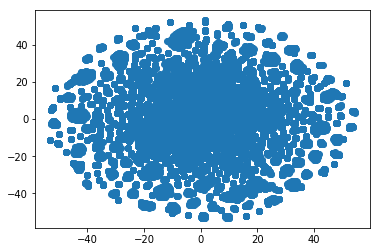

In [26]:
#Y = tsne(X, n_components, perplexity, n_iter, angle, n_jobs)
X_embedded = TSNE(n_jobs=4).fit_transform(repre_128)
print(X_embedded.shape)
plt.figure('Plot on 2d using TSNE')
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()

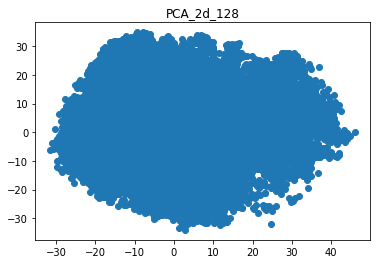

In [35]:
pca = PCA(n_components=2,random_state=2019).fit(repre_128)
pca_2d = pca.transform(repre_128)
plt.figure('Plot on 2d using TSNE')
plt.title("PCA_2d_128")
plt.scatter(pca_2d[:, 0], pca_2d[:, 1])
plt.show()

## Cluster

In [9]:
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# from sklearn.manifold import TSNE
from os.path import join
import matplotlib.pyplot as plt
import random

from tools import *

In [27]:
from sklearn import metrics

from sklearn.metrics import pairwise_distances,silhouette_samples, silhouette_score

In [10]:
random.seed(2019)
mms = MinMaxScaler()
mms.fit(repre_128)
data_transformed = mms.transform(repre_128)

In [31]:
def optimalK(data, nrefs=3,lowerClusters=2, maxClusters=30):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(lowerClusters, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'squared_distance':[],'silhouette_score':[],'gap':[]})
    Sum_of_squared_distances = []
    Silhouette = []
    for gap_index, k in enumerate(range(lowerClusters, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        silhouette = silhouette_score(data,km.labels_ )
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k,'squared_distance':origDisp,'silhouette_score':silhouette,'gap':gap}, ignore_index=True)

    return resultsdf

In [1]:
resultsdf=optimalK(data_transformed,lowerClusters=31,maxClusters=35)
resultsdf

In [23]:
resultsdf=optimalK(data_transformed,maxClusters=33)

In [24]:
write2file(pd.DataFrame(resultsdf), join(write_prefix,"optimal_k_result"))

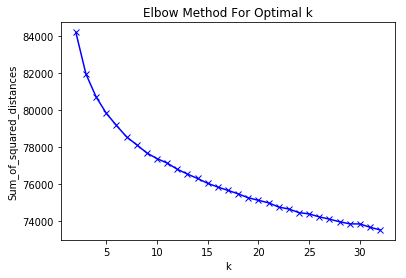

In [37]:
plt.plot(resultsdf['clusterCount'], resultsdf['squared_distance'], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

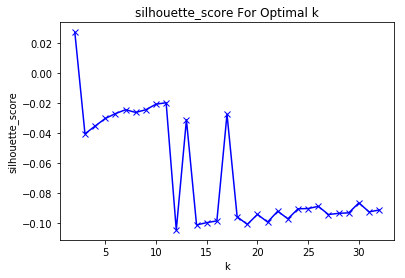

In [38]:
plt.plot(resultsdf['clusterCount'], resultsdf['silhouette_score'], 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score For Optimal k')
plt.show()

In [40]:
np.argmax(resultsdf['silhouette_score'][1:])

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


9

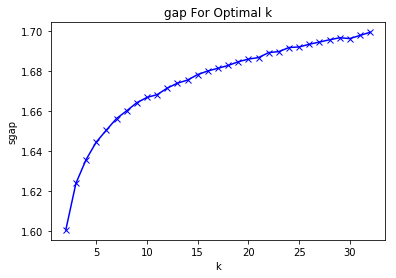

In [39]:
plt.plot(resultsdf['clusterCount'], resultsdf['gap'], 'bx-')
plt.xlabel('k')
plt.ylabel('sgap')
plt.title('gap For Optimal k')
plt.show()

In [35]:
resultsdf=read_data(join(write_prefix,"optimal_k_result"))
resultsdf

,clusterCount,squared_distance,silhouette_score,gap
0,2.0,84201.560938,0.027083,1.600698
1,3.0,81942.368146,-0.040548,1.624020
2,4.0,80712.886104,-0.035392,1.635868
3,5.0,79830.062456,-0.030356,1.644597
4,6.0,79172.037886,-0.027110,1.650613
5,7.0,78555.808626,-0.024513,1.656394
6,8.0,78128.108526,-0.026311,1.660248
7,9.0,77687.655452,-0.024521,1.664325
8,10.0,77380.799532,-0.020828,1.666954
9,11.0,77143.436002,-0.019854,1.668331


In [11]:
Sum_of_squared_distances = []
Silhouette = []
K = range(1,)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    labels = km.labels_
    Silhouette.append(metrics.silhouette_score(data_transformed, labels,metric='euclidean') )

In [26]:
np.argmax(resultsdf['gap'])

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


30

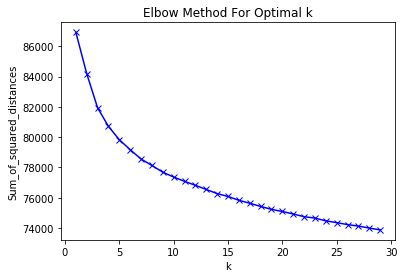

In [12]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Run kmeans with optimal K Intersection

In [41]:
random.seed(2019)
kmeans = KMeans(n_clusters=12)
kmeans.fit(data_transformed)
labels = kmeans.labels_
Counter(kmeans.labels_)

Counter({11: 1830,
         9: 4532,
         8: 2757,
         10: 1847,
         6: 3630,
         4: 1529,
         5: 3204,
         2: 3086,
         3: 6735,
         1: 4003,
         0: 2622,
         7: 3581})

In [9]:
labels = read_data(join(write_prefix,"kmeans_label"))
# write2file(pd.DataFrame({"cluster_id":kmeans.labels_}), join(write_prefix,"kmeans_label"))

In [10]:
pres_matrix_index = pres_matrix
pres_matrix_index.insert(loc=0, column='label', value=labels)
pres_matrix_index.head()

,label,74300000068,78112001103,00002411233,87701071218,00456066270,00002411533,00456201063,00002445385,00456261490,...,68094020462,00409729501,00409739172,00409779362,00409781124,00409792337,68516521102,68516521402,00409915801,49702020218
0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
## For each drug
valid_per_drug = [base_pred_each_ndcset(ade_df,top10_NDCs,[[i] for i in list(range(10))],\
                                        label_df.iloc[:,1:], diag_matrix, union=False, topNs=[1000]) for label, label_df in pres_matrix_index.groupby('label')]

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
## For predominant drugs
valid_per_drug = [base_pred_each_ndcset(ade_df,top10_NDCs,c,\
                                        label_df.iloc[:,1:], diag_matrix, topNs=[1000]) for label, label_df in pres_matrix_index.groupby('label')]

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
## Number of treated patients for different groups
num_treated_patients = pd.concat([valid_per_drug[0].iloc[:,:1]]+[valid_df.iloc[:,1] for valid_df in valid_per_drug], axis=1)
s_col = num_treated_patients.columns
num_treated_patients.columns =['drug_set'] + ["c_%d"%i for i in list(range(len(s_col)-1))]
num_treated_patients

,drug_set,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11
0,drug_0,0,2,2,2,2,1,2,5,1,9,0,0
1,drug_1,5,1,6,6,2,9,6,3,7,13,0,0
2,drug_2,0,0,0,1,0,0,0,3,0,0,0,0
3,drug_3,2,43,0,1,0,27,0,0,0,0,0,0
4,drug_4,2,20,105,4,3,88,93,68,83,65,0,0
5,drug_5,0,3,0,0,0,2,0,0,0,0,0,0
6,drug_6,0,1,0,1,0,0,0,1,0,0,0,0
7,drug_7,0,0,0,1,0,0,0,0,0,0,464,14
8,drug_8,1,3,0,2,0,0,0,0,0,0,0,0
9,drug_9,7,22,0,50,3,23,15,12,0,0,0,0


In [24]:
recall_df = pd.concat([valid_df[["recall%"]] for valid_df in valid_per_drug], axis=1)
recall_df=recall_df.apply(pd.to_numeric)
recall_df['mean']=recall_df.mean(axis=1)
recall_df['std']=recall_df.std(axis=1)
recall_df['range']=recall_df.iloc[:,-2:].apply(lambda x: "μ=%.2f, s=%.2f"%(x[0],x[1]),axis=1)
recall_df

,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,mean,std,range
0,0.00,1.77,0.80,0.96,1.12,0.48,0.48,3.37,0.80,2.89,0.00,0.0,1.055833,1.055987,"μ=1.06, s=1.06"
1,2.25,0.80,1.93,2.57,0.80,5.62,3.69,2.09,2.73,3.05,0.00,0.0,2.127500,1.545995,"μ=2.13, s=1.55"
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.33,0.00,0.00,0.00,0.0,0.110833,0.367593,"μ=0.11, s=0.37"
3,1.36,3.70,0.00,0.00,0.00,4.09,0.00,0.00,0.00,0.00,0.00,0.0,0.762500,1.451747,"μ=0.76, s=1.45"
4,1.56,3.90,4.09,2.14,1.17,5.07,4.87,3.12,3.90,4.29,0.00,0.0,2.842500,1.735243,"μ=2.84, s=1.74"
5,0.00,4.09,0.00,0.00,0.00,3.56,0.00,0.00,0.00,0.00,0.00,0.0,0.637500,1.429593,"μ=0.64, s=1.43"
6,0.00,0.53,0.00,0.53,0.00,0.00,0.00,1.60,0.00,0.00,0.00,0.0,0.221667,0.459362,"μ=0.22, s=0.46"
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.52,0.2,0.310000,0.969416,"μ=0.31, s=0.97"
8,0.30,2.40,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.275000,0.664737,"μ=0.27, s=0.66"
9,1.20,4.19,0.00,6.29,1.50,6.89,4.79,3.59,0.00,0.00,0.00,0.0,2.370833,2.527586,"μ=2.37, s=2.53"


In [25]:
precision_df = pd.concat([valid_df["precision%"] for valid_df in valid_per_drug], axis=1).apply(pd.to_numeric)
precision_df["mean"]=precision_df.mean(axis=1)
precision_df["std"]=precision_df.std(axis=1)
precision_df["range"]=precision_df.iloc[:,-2:].apply(lambda x: "μ=%.2f, s=%.2f"%(x[0],x[1]),axis=1)
precision_df

,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,mean,std,range
0,0.0,11.0,5.0,6.0,7.0,3.0,3.0,21.0,5.0,18.0,0.0,0.0,6.583333,6.575945,"μ=6.58, s=6.58"
1,14.0,5.0,12.0,16.0,5.0,35.0,23.0,13.0,17.0,19.0,0.0,0.0,13.250000,9.627435,"μ=13.25, s=9.63"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.500000,1.658312,"μ=0.50, s=1.66"
3,7.0,19.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,3.916667,7.454957,"μ=3.92, s=7.45"
4,8.0,20.0,21.0,11.0,6.0,26.0,25.0,16.0,20.0,22.0,0.0,0.0,14.583333,8.901857,"μ=14.58, s=8.90"
5,0.0,23.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,3.583333,8.035944,"μ=3.58, s=8.04"
6,0.0,3.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.250000,2.586020,"μ=1.25, s=2.59"
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0,1.583333,4.957458,"μ=1.58, s=4.96"
8,1.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916667,2.215789,"μ=0.92, s=2.22"
9,4.0,14.0,0.0,21.0,5.0,23.0,16.0,12.0,0.0,0.0,0.0,0.0,7.916667,8.440560,"μ=7.92, s=8.44"


## Union (run for cluster result, ignore the last part)

In [24]:
## For predominant drugs (combination of drugs)
valid_per_drug = [base_pred_each_ndcset(ade_df,top10_NDCs,c,\
                                        label_df.iloc[:,1:], diag_matrix, topNs=[100],union=False) for label, label_df in pres_matrix_index.groupby('label')]

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
## Number of treated patients for different groups
num_treated_patients = pd.concat([valid_per_drug[0].iloc[:,:1]]+[valid_df.iloc[:,1] for valid_df in valid_per_drug], axis=1)
s_col = num_treated_patients.columns
num_treated_patients.columns =['drug_set'] + ["c_%d"%i for i in list(range(len(s_col)-1))]
num_treated_patients

,drug_set,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11
0,"drug_0,drug_7,drug_9",0,0,0,0,0,0,0,0,0,0,0,0
1,"drug_1,drug_4,drug_9",0,0,0,0,0,0,0,0,0,0,0,0
2,drug_7,0,0,0,1,0,0,0,0,0,0,464,14
3,drug_4,2,20,105,4,3,88,93,68,83,65,0,0
4,"drug_0,drug_1",0,0,1,2,1,0,0,1,0,1,0,0
5,"drug_3,drug_4,drug_9",0,0,0,0,0,0,0,0,0,0,0,0
6,"drug_3,drug_7,drug_8",0,0,0,0,0,0,0,0,0,0,0,0
7,"drug_0,drug_1,drug_2,drug_9",0,0,0,0,0,0,0,0,0,0,0,0
8,"drug_1,drug_8",0,0,0,0,0,0,0,0,0,0,0,0
9,drug_4,2,20,105,4,3,88,93,68,83,65,0,0


In [26]:
recall_df = pd.concat([valid_df[["recall%"]] for valid_df in valid_per_drug], axis=1)
recall_df=recall_df.apply(pd.to_numeric)
recall_df['mean']=recall_df.mean(axis=1)
recall_df['std']=recall_df.std(axis=1)
recall_df['range']=recall_df.iloc[:,-2:].apply(lambda x: "μ=%.2f, s=%.2f"%(x[0],x[1]),axis=1)
recall_df

,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,recall%,mean,std,range
0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
1,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
2,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3.52,0.2,0.310000,0.969416,"μ=0.31, s=0.97"
3,1.56,3.9,4.09,2.14,1.17,5.07,4.87,3.12,3.9,4.29,0.00,0.0,2.842500,1.735243,"μ=2.84, s=1.74"
4,0.00,0.0,0.64,0.96,0.64,0.00,0.00,0.80,0.0,0.16,0.00,0.0,0.266667,0.359753,"μ=0.27, s=0.36"
5,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
6,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
7,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
8,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
9,1.56,3.9,4.09,2.14,1.17,5.07,4.87,3.12,3.9,4.29,0.00,0.0,2.842500,1.735243,"μ=2.84, s=1.74"


In [27]:
precision_df = pd.concat([valid_df["precision%"] for valid_df in valid_per_drug], axis=1).apply(pd.to_numeric)
precision_df["mean"]=precision_df.mean(axis=1)
precision_df["std"]=precision_df.std(axis=1)
precision_df["range"]=precision_df.iloc[:,-2:].apply(lambda x: "μ=%.2f, s=%.2f"%(x[0],x[1]),axis=1)
precision_df

,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,precision%,mean,std,range
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0,1.583333,4.957458,"μ=1.58, s=4.96"
3,8.0,20.0,21.0,11.0,6.0,26.0,25.0,16.0,20.0,22.0,0.0,0.0,14.583333,8.901857,"μ=14.58, s=8.90"
4,0.0,0.0,4.0,6.0,4.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,1.666667,2.248456,"μ=1.67, s=2.25"
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,"μ=0.00, s=0.00"
9,8.0,20.0,21.0,11.0,6.0,26.0,25.0,16.0,20.0,22.0,0.0,0.0,14.583333,8.901857,"μ=14.58, s=8.90"
